In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

from joblib import dump, load
import mlflow
import dagshub
import pickle
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
dagshub.init("Projet7", "alexandre", mlflow=True)

Repository initialized!

In [3]:
mlflow.set_tracking_uri("https://dagshub.com/alexandre/Projet7.mlflow")

In [4]:
mlflow.set_experiment("XGBoost")

<Experiment: artifact_location='mlflow-artifacts:/04e0537cf3f7468b8c6418159d45db8e', creation_time=1692228764226, experiment_id='0', last_update_time=1692228764226, lifecycle_stage='active', name='XGBoost', tags={}>

In [5]:
# chargement de base de données
df = pd.read_csv("../Data/Processed/fichier_xgb.csv", index_col="SK_ID_CURR")

In [6]:
# Définir la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn_weight = 10.0  # poids pour les faux négatifs
    fp_weight = 10.0  # poids pour les faux positifs
    return cm[0, 1] * fp_weight + cm[1, 0] * fn_weight

In [7]:
# Faire une fonction d'évaluation personnalisée pour GridSearch
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [8]:
# Séparer les données d'entraînement et de test
train_test_data = df.dropna(subset=["TARGET"])
X = train_test_data.drop(columns=["TARGET"])
y = train_test_data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
# Initialiser le DummyClassifier
dummy_clf = DummyClassifier(
    strategy="most_frequent"
)  # ou une autre stratégie de votre choix

# Former le modèle avec les données d'entraînement
dummy_clf.fit(X_train, y_train)

# Prédire avec le DummyClassifier
y_pred_dummy = dummy_clf.predict(X_test)

# Calculer les métriques pour le DummyClassifier
roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

# Enregistrement de la matrice de confusion pour le DummyClassifier
path_cm_dummy = "../src/models/confusion_matrix_dummy.txt"
with open(path_cm_dummy, "w") as f:
    f.write(str(cm_dummy))

# Début de l'exécution MLflow pour le modèle Dummy
with mlflow.start_run(run_name="Dummy") as run:
    # Enregistrer les métriques pour le DummyClassifier
    mlflow.log_metric("roc_auc_dummy", roc_auc_dummy)
    mlflow.log_metric("accuracy", accuracy_dummy)

    # Enregistrer la matrice de confusion en tant qu'artefact
    mlflow.log_artifact(path_cm_dummy)

    # Enregistrer le modèle DummyClassifier
    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [23]:
print("ROC AUC =", roc_auc_dummy)
print("ACCURACY =", accuracy_dummy)
print(cm_dummy)

ROC AUC = 0.5
ACCURACY = 0.9188213484242365
[[56502     0]
 [ 4992     0]]


In [11]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [7],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)

In [13]:
path_cm_xgb = "../src/models/confusion_matrix_xgb.txt"
cmxgb = confusion_matrix(y_test, y_pred)

# Enregistrer la matrice de confusion sous forme de texte
with open(path_cm_xgb, "w") as f:
    f.write(str(cmxgb))

with mlflow.start_run(run_name="XGB") as run:

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    score_matrix = custom_loss(y_test, y_pred)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("ROC AUC Score", roc_auc)
    mlflow.log_metric("ACCURACY", accuracy)
    mlflow.log_metric("SCORE MATRIX", score_matrix)

    # Enregistrer la matrice de confusion sous forme de texte
    mlflow.log_artifact(path_cm_xgb)

    # Enregistrer les paramètres
    mlflow.log_params({"max_depth": 7, "learning_rate": 0.1, "n_estimators": 200})

    # Enregistrer le modèle
    mlflow.sklearn.log_model(grid_search_xgb_opti.best_estimator_, "best_model")

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.


In [14]:
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print(f"ACCURACY: {accuracy*100:.2f}%")
print(f"Confusion Matrix: {cmxgb}")
print(f"SCORE MATRICE: {score_matrix}")

ROC AUC Score: 61.59%
ACCURACY: 81.48%
Confusion Matrix: [[48217  8285]
 [ 3103  1889]]
SCORE MATRICE: 113880.0


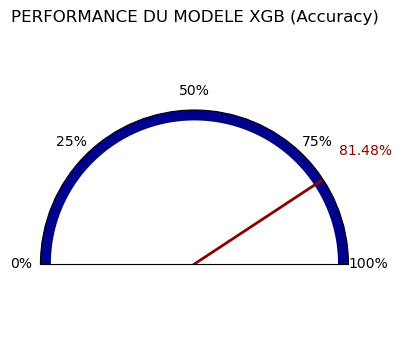

In [15]:
def draw_gauge(accuracy_score):
    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (Accuracy)", va="bottom")

    plt.show()

    fig.savefig("../src/utils/images/jauge_xgb.png")

accuracy_value = accuracy
draw_gauge(accuracy_value)

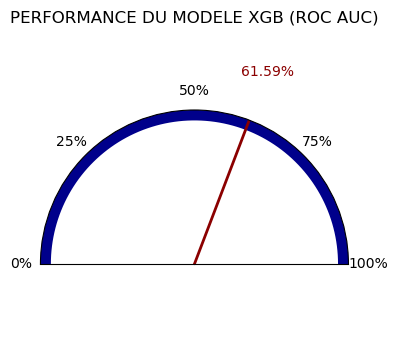

In [16]:
def draw_gauge(accuracy_score):
    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (ROC AUC)", va="bottom")

    plt.show()

    fig.savefig("../src/utils/images/jauge_xgb_auc.png")

accuracy_value = roc_auc
draw_gauge(accuracy_value)

In [17]:
y_pred_proba = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

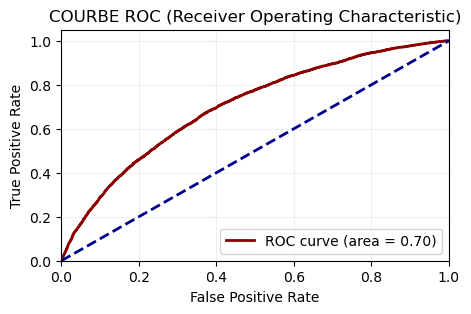

In [18]:
# Créer la figure et l'axe
fig, ax = plt.subplots(figsize=(5, 3))

# Tracer la courbe ROC sur l'axe
ax.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')  # ligne diagonale pour un modèle aléatoire
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('COURBE ROC (Receiver Operating Characteristic)')
ax.legend(loc="lower right")
ax.grid(alpha=0.2)
plt.show()

# Sauvegarder la figure
fig.savefig("../src/utils/images/courbe_roc.png")


In [19]:
mlflow.end_run()

In [20]:
# Enregistrer le modèle et les variables associées avec pickle
file_path = "../output/xgb_model.pkl"
with open(file_path, "wb") as f:
    pickle.dump(
        {"model": grid_search_xgb_opti, "roc_auc": roc_auc, "confusion_matrix": cmxgb},
        f,
    )

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.
